In [1]:
pip install pytorch-pretrained-bert


The following command must be run outside of the IPython shell:

    $ pip install pytorch-pretrained-bert

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [1]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [2]:
text = "Here is the sentence I want embeddings for."
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
marked_text = "[CLS] " + text + " [SEP]"

print (marked_text)

[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP]


In [3]:
tokenized_text = tokenizer.tokenize(marked_text)
print (tokenized_text)

['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


In [4]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [5]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
  print (tup)

('[CLS]', 101)
('after', 2044)
('stealing', 11065)
('money', 2769)
('from', 2013)
('the', 1996)
('bank', 2924)
('vault', 11632)
(',', 1010)
('the', 1996)
('bank', 2924)
('robber', 27307)
('was', 2001)
('seen', 2464)
('fishing', 5645)
('on', 2006)
('the', 1996)
('mississippi', 5900)
('river', 2314)
('bank', 2924)
('.', 1012)
('[SEP]', 102)


In [6]:
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [8]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [9]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


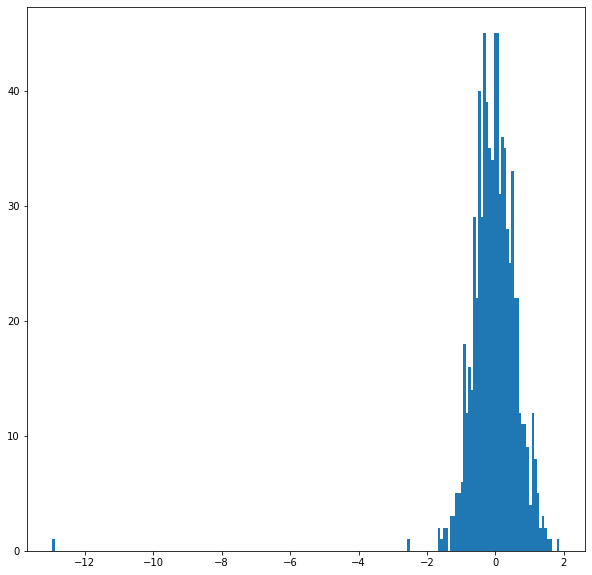

In [10]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [11]:
# Convert the hidden state embeddings into single token vectors

# Holds the list of 12 layer embeddings for each token
# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  
  # Holds 12 layers of hidden states for each token 
  hidden_layers = [] 
  
  # For each of the 12 layers...
  for layer_i in range(len(encoded_layers)):
    
    # Lookup the vector for `token_i` in `layer_i`
    vec = encoded_layers[layer_i][batch_i][token_i]
    
    hidden_layers.append(vec)
    
  token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))

Number of tokens in sequence: 22
Number of layers per token: 12


In [12]:
concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]

summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]

In [13]:
sentence_embedding = torch.mean(encoded_layers[11], 1)

In [14]:
print ("Our final sentence embedding vector of shape:"), sentence_embedding[0].shape[0]

Our final sentence embedding vector of shape:


(None, 768)

In [15]:
print (text)

After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.


In [16]:
for i,x in enumerate(tokenized_text):
  print (i,x)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [17]:
print ("First fifteen values of 'bank' as in 'bank robber':")
summed_last_4_layers[10][:15]

First fifteen values of 'bank' as in 'bank robber':


tensor([ 1.1868, -1.5298, -1.3770,  1.0648,  3.1446,  1.4003, -4.2407,  1.3946,
        -0.1170, -1.8777,  0.1091, -0.3862,  0.6744,  2.1924, -4.5306])

In [18]:
print ("First fifteen values of 'bank' as in 'bank vault':")
summed_last_4_layers[6][:15]

First fifteen values of 'bank' as in 'bank vault':


tensor([ 2.1319, -2.1413, -1.6260,  0.8638,  3.3173,  0.1797, -4.4853,  3.1215,
        -0.9740, -3.1780,  0.1045, -1.5481,  0.4758,  1.1703, -4.4859])

In [19]:
print ("First fifteen values of 'bank' as in 'river bank':")
summed_last_4_layers[19][:15]

First fifteen values of 'bank' as in 'river bank':


tensor([ 1.1295, -1.4725, -0.7296, -0.0901,  2.4970,  0.5330,  0.9742,  5.1834,
        -1.0692, -1.5941,  1.9261,  0.7119, -0.9809,  1.2127, -2.9812])

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare "bank" as in "bank robber" to "bank" as in "river bank"
different_bank = cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[19].reshape(1,-1))[0][0]

# Compare "bank" as in "bank robber" to "bank" as in "bank vault" 
same_bank = cosine_similarity(summed_last_4_layers[10].reshape(1,-1), summed_last_4_layers[6].reshape(1,-1))[0][0]

In [21]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault':",  same_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault': 0.9456754


In [22]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank':",  different_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank': 0.6797334
